In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"
from keras.layers import Input, Dense, Flatten, Reshape
from sklearn.feature_extraction import image as sk_image
from concurrent.futures import ProcessPoolExecutor
import cartopy.feature as cfeature
from keras.models import Model
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d 
from scipy import ndimage
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow import keras    
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.cluster import DBSCAN
from pyhdf.SD import SD, SDC
import matplotlib as mpl
#tf.config.threading.set_inter_op_parallelism_threads(1)
from extract_training_data import *
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from pyhdf.error import HDF4Error
from functions import *
from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans, MiniBatchKMeans
import joblib
import plot_functions
import importlib 
importlib.reload(plot_functions)
from plot_functions import *
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping


# Visualize the result


total cores: 256


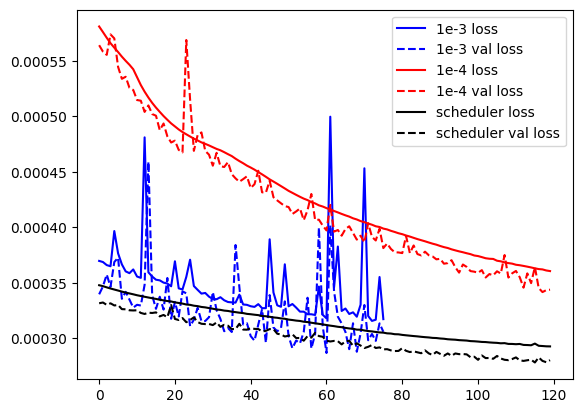

In [2]:
import pickle
with open('training_history_landmask_150k_1e3.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

with open('training_history_landmask_1e-4_150k.pkl', 'rb') as f:
    loaded_history_2 = pickle.load(f)
    
with open('training_history_landmask_150k.pkl', 'rb') as f:
    loaded_history_3 = pickle.load(f)

plt.plot(loaded_history["loss"][30:150], "b", label="1e-3 loss")
plt.plot(loaded_history["val_loss"][30:150], "b--", label="1e-3 val loss")

plt.plot(loaded_history_2["loss"][30:150], "r", label="1e-4 loss")
plt.plot(loaded_history_2["val_loss"][30:150], "r--", label="1e-4 val loss")

plt.plot(loaded_history_3["loss"][30:150], "k", label="scheduler loss")
plt.plot(loaded_history_3["val_loss"][30:150], "k--", label="scheduler val loss")

plt.legend()

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,"  , len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


#bands = [6, 7, 20, 28, 28, 31]
bands=[29]
#bands=[1]
folder = "/scratch/fslippe/modis/MOD02/daytime_1km/ /scratch/fslippe/modis/MOD02/boundary_1km/ /scratch/fslippe/modis/MOD02/night_1km/"


1 Physical GPUs, 1 Logical GPUs


2023-10-17 16:20:05.292989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21336 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:25:00.0, compute capability: 7.5


In [ ]:
import importlib
import extract_training_data
importlib.reload(extract_training_data)
from extract_training_data import *
#folder = "/scratch/fslippe/modis/MOD02/daytime_1km/"# /scratch/fslippe/modis/MOD02/boundary_1km/"# /scratch/fslippe/modis/MOD02/night_1km/"

start = "20201201"
end = "20210430"
# start = "20210401"
# end = "20210430"


start_converted = convert_to_day_of_year(start)
end_converted = convert_to_day_of_year(end)
print(start_converted)
print(end_converted)
x, dates, masks = extract_1km_data(folder, bands=bands, start_date=start_converted, end_date=end_converted)
x, dates, masks = zip(*[(xi, date, mask) for xi, date, mask in zip(x, dates, masks) if (xi.shape[0] > 64) and (xi.shape[1] > 64)])
x = list(x)
dates = list(dates)

#x = extract_250m_data(folder, bands=[1], start_date=start_converted, end_date=end_converted)
len(masks)




In [4]:
import autoencoder
import importlib
importlib.reload(autoencoder)
from autoencoder import SobelFilterLayer, SimpleAutoencoder
patch_size = 64
#normalized_patches = np.concatenate([autoencoder.extract_patches(n_d) for n_d in normalized_data], axis=0)

In [5]:
from autoencoder import SobelFilterLayer, SimpleAutoencoder
patch_size = 64
print(len(bands))
autoencoder_predict = SimpleAutoencoder(len(bands), patch_size, patch_size)

#encoder = load_model("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_band(6,20,29)_encoder")
encoder = load_model("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_150k_scheduler_band(29)_filter_encoder")
max_vals = np.load("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_band(29)_max_vals.npy")


1


In [ ]:
val_data = np.load("/scratch/fslippe/modis/MOD02/test_data/normalized_testpatches_dnb_landmask_150k_band(29)_winter20_21.npy")
encoded_patches = encoder.predict(val_data)
encoded_patches_flat = encoded_patches.reshape(encoded_patches.shape[0], -1)
gc.collect()

In [ ]:
#cluster = MiniBatchKMeans(11, batch_size=32, random_state=42).fit(encoded_patches_flat)
#joblib.dump(cluster, '/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_150k_scheduler_band(29)_filter_cluster.pkl')

In [6]:
### EXTRACT CAO AND NOn CAO CASES
import importlib
import extract_training_data
importlib.reload(extract_training_data)
from extract_training_data import *
# start = "20230303"
# end = "20230306"
start = "20201201"
end = "20210401"
#start = "20210701"
#end = "20210702"
start_converted = convert_to_day_of_year(start)
end_converted = convert_to_day_of_year(end)
#x_cao, dates_cao, masks_cao = extract_1km_data("/scratch/fslippe/modis/MOD02/july_2021/", bands=bands, start_date=start_converted, end_date=end_converted)

# x_cao, dates_cao, masks_cao, lon_lats = extract_1km_data("/scratch/fslippe/modis/MOD02/cao_test_data/",
#                                                          bands=bands,
#                                                          start_date=start_converted,
#                                                          end_date=end_converted,
#                                                          return_lon_lat=True)
x_cao, dates_cao, masks_cao, lon_lats = extract_1km_data(folder,
                                                         bands=bands,
                                                         start_date=start_converted,
                                                         end_date=end_converted,
                                                         return_lon_lat=True)
x_cao, dates_cao, masks_cao, lon_lats = zip(*[(xi, date, mask, lon_lat) for xi, date, mask, lon_lat in zip(x_cao, dates_cao, masks_cao, lon_lats) if (xi.shape[0] > 64) and (xi.shape[1] > 64)])

x_cao = list(x_cao)
dates_cao = list(dates_cao)


total cores: 256
['/scratch/fslippe/modis/MOD02/daytime_1km/', '/scratch/fslippe/modis/MOD02/boundary_1km/', '/scratch/fslippe/modis/MOD02/night_1km/']


100%|██████████| 122/122 [02:37<00:00,  1.29s/it] 


In [46]:
#### EXTRACTING AND ENCODING PATCHES + SAVING indexes of belonging files
import functions
importlib.reload(functions)
from functions import *
cluster_map_cao = []
patches_cao, all_lon_patches_cao, all_lat_patches_cao, starts_cao, ends_cao, shapes_cao, n_patches_tot_cao, indices = generate_patches(x_cao,
                                                                                                                                       masks_cao,
                                                                                                                                       lon_lats,
                                                                                                                                       max_vals,
                                                                                                                                       autoencoder_predict)

0/2707
1/2707
2/2707
3/2707
4/2707
5/2707
6/2707
7/2707
8/2707
9/2707
10/2707
11/2707
12/2707
13/2707
14/2707
15/2707
16/2707
17/2707
18/2707
19/2707
20/2707
21/2707
22/2707
23/2707
24/2707
25/2707
26/2707
27/2707
28/2707
29/2707
30/2707
31/2707
32/2707
33/2707
34/2707
35/2707
36/2707
37/2707
38/2707
39/2707
40/2707
41/2707
42/2707
43/2707
44/2707
45/2707
46/2707
47/2707
48/2707
49/2707
50/2707
51/2707
52/2707
53/2707
54/2707
55/2707
56/2707
57/2707
58/2707
59/2707
60/2707
61/2707
62/2707
63/2707
64/2707
65/2707
66/2707
67/2707
68/2707
69/2707
70/2707
71/2707
72/2707
73/2707
74/2707
75/2707
76/2707
77/2707
78/2707
79/2707
80/2707
81/2707
82/2707
83/2707
84/2707
85/2707
86/2707
87/2707
88/2707
89/2707
90/2707
91/2707
92/2707
93/2707
94/2707
95/2707
96/2707
97/2707
98/2707
99/2707
100/2707
101/2707
102/2707
103/2707
104/2707
105/2707
106/2707
107/2707
108/2707
109/2707
110/2707
111/2707
112/2707
113/2707
114/2707
115/2707
116/2707
117/2707
118/2707
119/2707
120/2707
121/2707
122/2707
123

In [13]:
n_patches = len(patches_cao)
n_patches

411668

In [14]:
encoded_patches_cao_1 = encoder.predict(patches_cao[:n_patches // 2])
encoded_patches_cao_2 = encoder.predict(patches_cao[n_patches // 2:])

encoded_patches_cao = np.concatenate([encoded_patches_cao_1, encoded_patches_cao_2])
encoded_patches_flat_cao = encoded_patches_cao.reshape(encoded_patches_cao.shape[0], -1)

gc.collect()

2023-10-17 16:31:10.761181: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


4087

In [17]:
cluster = joblib.load('/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_150k_scheduler_band(29)_filter_cluster_lab2.pkl')

labels = cluster.predict(encoded_patches_flat_cao)


In [ ]:
index_list = [0,1,2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19]
#index_list = range(len(x_cao))
#index_list = [2]

#cluster_predict = cluster.predict(encoded_patches_flat_cao)
labels = cluster_predict#.labels_
cluster_map_cao = []

global_min = np.min([np.min(cm) for cm in cluster.labels_])
global_max = np.max([np.max(cm) for cm in cluster.labels_])+2
print(global_max)
plot_img_cluster_mask(x_cao,
                      labels,
                      masks_cao,
                      starts_cao,
                      ends_cao,
                      shapes_cao,
                      indices,
                      dates_cao,
                      n_patches_tot_cao,
                      patch_size,
                      global_min,
                      global_max,
                      index_list,
                      save=None)


In [29]:
len(n_patches_tot_cao)

2707

In [44]:
print(ends_cao[2]-ends_cao[0])
print(n_patches_tot_cao[2])
indices[2]

#x_cao[2].shape

315
315


<tf.Tensor: shape=(315, 1), dtype=int64, numpy=
array([[  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 68],
       [ 69],
       [ 70],
       [ 71],
       [ 72],
       [ 73],
       [ 74],
       [ 75],
       [ 76],
       [ 77],
       [ 78],
       [ 79],
       [ 84],
       [ 85],
       [ 86],
       [ 87],
       [ 88],
       [ 89],


In [34]:
patches_cao.shape
desired_label = 2
size_threshold = 15
import functions
importlib.reload(functions)
from functions import *

patches_w_cao = get_patches_of_img_cao(labels, patches_cao, starts_cao, ends_cao, shapes_cao, indices, global_max, n_patches_tot_cao, desired_label, size_threshold, len(dates_cao),  patch_size)


#train, test = train_test_split(patches_w_cao, test_size=0.15)

0
0 38 38 (694, 296)
[ 1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


IndexError: index 38 is out of bounds for axis 0 with size 38

In [ ]:
# TRY TRAINING ON PATCHES EXTRACTED
patch_size = 64
bands = [1]  # You might need to specify the bands here
autoencoder = SimpleAutoencoder(len(bands), patch_size, patch_size)

# Set up your optimizer and compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model = autoencoder.model(optimizer=optimizer, loss="combined")

# Train the model on your dataset
batch_size = 32 
from read_tf import scheduler
lr_schedule = LearningRateScheduler(scheduler, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

history = model.fit(train, train, validation_data=(test, test), epochs=500, callbacks=[early_stopping, lr_schedule])

model.save("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_150k_scheduler_band(29)_filter_secondary_autoencoder")
autoencoder.encoder.save("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_150k_scheduler_band(29)_filter_encoder")
autoencoder.decoder.save("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_dnb_landmask_150k_scheduler_band(29)_filter_decoder")

In [ ]:
march_idx = np.where(np.array(dates_cao) == str(convert_to_day_of_year("20210301")))[0][0]
projection = ccrs.Stereographic(central_latitude=90)

x_grid, y_grid, counts = generate_hist_map(n_patches_tot_cao,
                                        indices,
                                        labels,
                                        starts_cao,
                                        ends_cao,  
                                        shapes_cao,
                                        all_lon_patches_cao,
                                        all_lat_patches_cao,  
                                        dates_cao,
                                        desired_label=2,
                                        size_threshold=15,
                                        patch_size=patch_size,
                                        global_max=global_max,
                                        projection=projection,
                                        grid_resolution = 100e3)



In [ ]:
# Visualize the result

tot_days = int(dates_cao[-1]) - int(dates_cao[0])

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(15, 8), dpi=200)
plt.title("Percentage of time with predicted CAO in Jan/Feb")
ax.set_extent([-35, 35, 55, 84], ccrs.PlateCarree())  # Set extent to focus on the Arctic
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
c = ax.contourf(x_grid, y_grid, counts/tot_days*100, transform=projection, levels=10, cmap="turbo")
plt.colorbar(c, ax=ax, orientation='vertical', label='[%]')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.show()
